In [1]:
import sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re

import gensim
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import shuffle

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten, Dropout, Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv('train.csv')
df2 = pd.read_csv('FinalBalancedDataset.csv')

In [3]:
df2 = df2[['tweet', 'Toxicity']].rename(columns={'Toxicity': 'toxic'})

In [4]:
df['toxic'] = df.copy()[['toxic']]
df = df[['comment_text', 'toxic']].rename(columns={'comment_text': 'tweet'})

In [5]:
min_len = (df['toxic'] == 1).sum()
df_undersample = df[df['toxic'] == 0].sample(n=min_len, random_state=201)
df = pd.concat([df_undersample, df[df['toxic'] == 1]])
df = shuffle(df)

In [6]:
df_all = pd.concat([df, df2], ignore_index=True)

In [7]:
Y = df_all.toxic
X = df_all.drop('toxic', axis = 1)

In [8]:
tweets = X.copy()
tweets.reset_index(inplace = True, drop = True)
tweets.head()

,tweet
0,I don't think he's a troll. I think he's an Is...
1,"""::::::could you point to me where in your est..."
2,"""Contoversies page==\nWHAT HAPPENED TO THE CON..."
3,I got refresh 4 times faggot.
4,"""\n\n What the hell do u mean \n\ncough* *coug..."


In [9]:
class Preprocessor():
    def __init__(self):
        pass
    
    def __stem_word(self, text):
        por = PorterStemmer()
        return por.stem_sentence(text)
    
    def __clear_stop_words(self, text):
        return remove_stopwords(text) 
    
    def __re_process(self, text):
        text = re.sub(r'@[A-Za-z0-9]+', '', text) #Removing tags
        text = re.sub(r'#', '', text) # Removing the "#" symbol
        text = re.sub(r'RT', '', text) # Removing RT
        text = re.sub(r'https?:\/\/\S+', '', text) #Remove links
        text = re.sub(r'[^A-Za-z\s]+', '', text) # Remove not letters
        text =  " ".join(text.split())
        return text.lower()
    
    def cleaning(self, x_data):
        clear_x_data = x_data.apply(self.__re_process)
        clear_x_data = clear_x_data.apply(self.__clear_stop_words)
        clear_x_data = clear_x_data.apply(self.__stem_word)
        return clear_x_data


In [10]:
process = Preprocessor()
clear_data = process.cleaning(tweets['tweet'])
tweets['tweet'] = clear_data

In [11]:
tweets.head()

,tweet
0,dont think he troll think he islamist photo pl...
1,point estim damag articl revert edit damag art...
2,contoversi page happen controversi page fella ...
3,got refresh time faggot
4,hell u mean cough cough excus hell accus disru...


## Embedding

In [12]:
DIM = 200

split_words = [d.split() for d in tweets['tweet']]
w2v_model = gensim.models.Word2Vec(sentences = split_words, vector_size = DIM, window = 10, min_count = 1)

In [13]:
len(w2v_model.wv.key_to_index.keys()) 

83138

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(split_words) 
X_data = tokenizer.texts_to_sequences(split_words)
X_data = pad_sequences(X_data, padding = 'pre', maxlen = 20)

In [15]:
vocab_size = len(tokenizer.word_index) + 1 
vocab = tokenizer.word_index

In [16]:
def get_weights_matrix(model) :
    weights_matrix = np.zeros((vocab_size, DIM))
    
    for word, i in vocab.items() :
        weights_matrix[i] = model.wv[word]
        
    return weights_matrix


embedding_vectors = get_weights_matrix(w2v_model) 

In [17]:
model = Sequential()

model.add(Embedding(vocab_size, output_dim = DIM, weights = [embedding_vectors], input_length = 20)) 
model.add(Dropout(0.8))

model.add(LSTM(128))
model.add(Dropout(0.8))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.7))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.7))

model.add(Dense(1, activation = 'sigmoid'))

In [18]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 200)           16627800  
                                                                 
 dropout (Dropout)           (None, 20, 200)           0         
                                                                 
 lstm (LSTM)                 (None, 128)               168448    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X_data, Y, test_size = 0.2)

es = EarlyStopping(patience=3, 
                   monitor='loss')

# train the model 
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 5,
                 callbacks=es, batch_size = 256, shuffle=True, verbose = 1)

Epoch 1/5
273/273 [==============================] - 94s 332ms/step - loss: 0.5953 - accuracy: 0.6736 - val_loss: 0.3175 - val_accuracy: 0.8637
Epoch 2/5
273/273 [==============================] - 89s 327ms/step - loss: 0.3987 - accuracy: 0.8393 - val_loss: 0.2637 - val_accuracy: 0.8928
Epoch 3/5
273/273 [==============================] - 91s 332ms/step - loss: 0.3365 - accuracy: 0.8687 - val_loss: 0.2440 - val_accuracy: 0.8976
Epoch 4/5
273/273 [==============================] - 90s 330ms/step - loss: 0.2926 - accuracy: 0.8894 - val_loss: 0.2257 - val_accuracy: 0.9099
Epoch 5/5
273/273 [==============================] - 90s 329ms/step - loss: 0.2510 - accuracy: 0.9072 - val_loss: 0.2195 - val_accuracy: 0.9148


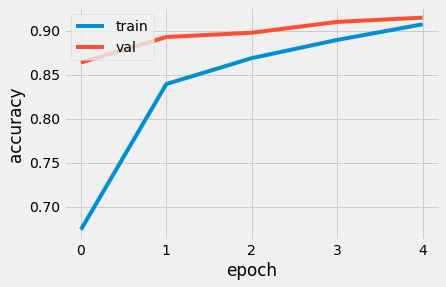

In [20]:
plt.style.use('fivethirtyeight')

# visualize the models accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()  

In [21]:
y_predict_test = model.predict(x_test)
y_predict_test = (y_predict_test > 0.5).astype(int)
y_test = y_test.to_numpy()

In [22]:
print(f1_score(y_test, y_predict_test))
print(accuracy_score(y_test, y_predict_test))

0.9028847408954445
0.9148107860537013


In [23]:
model.save('FinalModel.model', save_format = 'h5')